<a href="https://colab.research.google.com/github/sakira/TensorflowInPractice/blob/master/IntroToTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format='-', start=0, end=None):
  #plt.figure(figsize=(10, 6))
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('time')
  plt.ylabel('value')
  plt.grid(True)
def trend(time, slope=0):
  return slope * time

# time = np.arange(4 * 365 + 1)
# baseline = 10
# series = trend(time, 0.1)
# plot_series(time, series)
# plt.show()

# def seasonal_pattern(season_time):
#   return np.where(season_time < 0.4,
#                   np.cos(season_time * 2* np.pi),
#                   1 / np.exp(3 * season_time))

def seasonal_pattern(season_time):
  return np.where(season_time < 0.1,
                  np.cos(season_time * 7 * np.pi),
                  1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


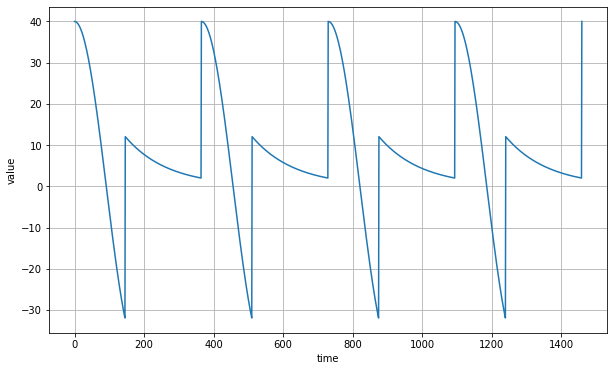

In [2]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series)
plt.show()

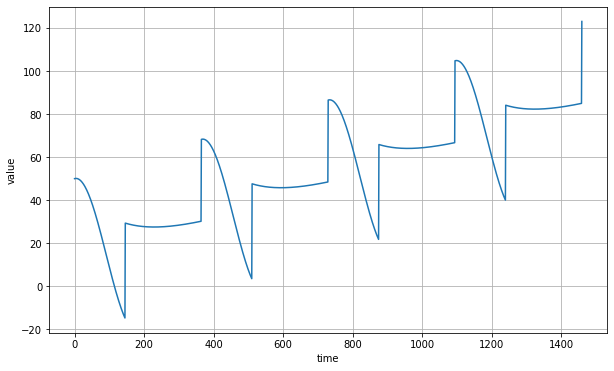

In [3]:
# add trend
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series)
plt.show()

In [0]:
# adding another feature: noise

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

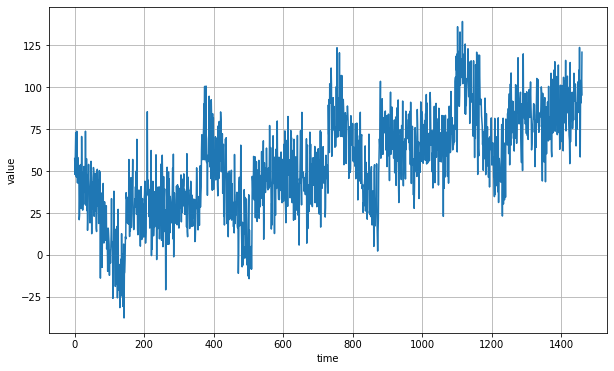

In [6]:
noise_level= 15
noisy_series = series + noise(time, noise_level, seed=42)
plot_series(time, noisy_series)
plt.show()

In [0]:
# add feature: autocorrelation
def autocorrelation(time, amplitude, seed=None):
  rnd = np.random.RandomState(seed)
  φ1 = 0.5
  φ2 = -0.1
  ar = rnd.randn(len(time) + 50)
  ar[:50] = 100
  for step in range(50, len(time) + 50):
    ar[step] += φ1 * ar[step - 50]
    ar[step] += φ2 * ar[step - 33]
  return ar[50:] * amplitude

def autocorrelation2(time, amplitude, seed=None):
  rnd = np.random.RandomState(seed)
  φ = 0.8
  ar = rnd.randn(len(time) + 1)
  for step in range(1, len(time) +1 ):
    ar[step] += φ * ar[step - 1]
  return ar[1: ] * amplitude
  

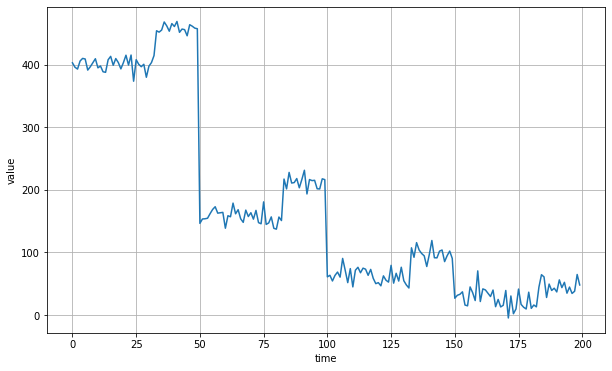

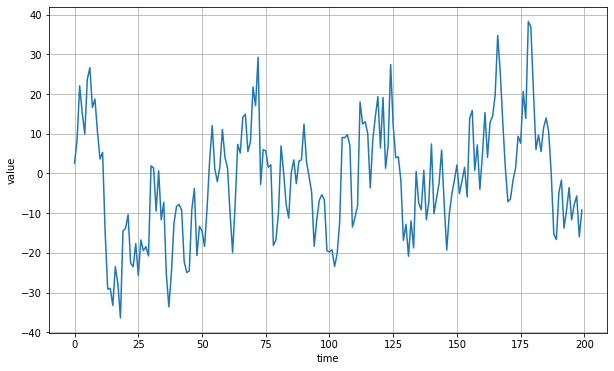

In [8]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

series = autocorrelation2(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

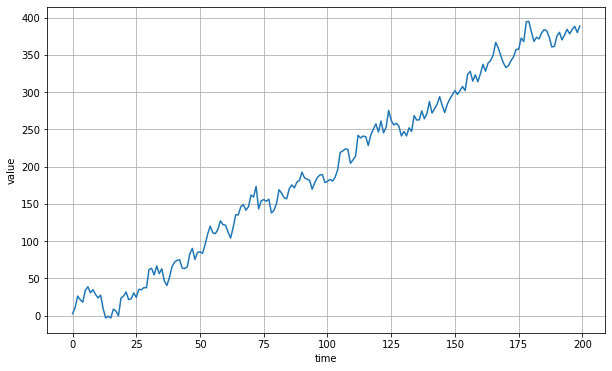

In [10]:
series = autocorrelation2(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

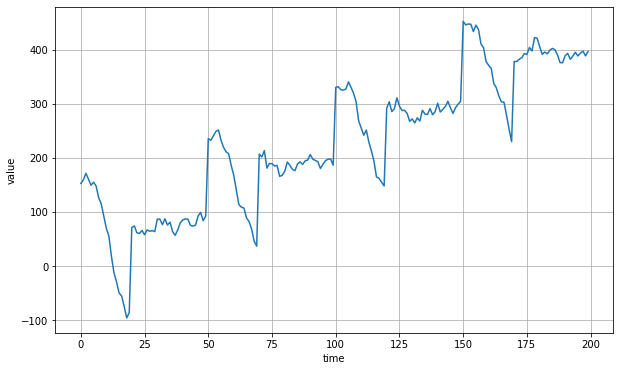

In [12]:
series = autocorrelation2(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

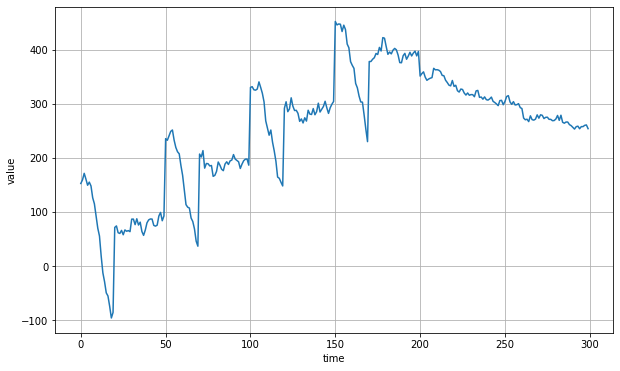

In [15]:
series = autocorrelation2(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation2(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) +550
series[200:] = series2[200:]
plot_series(time[:300], series[:300])
plt.show()

In [0]:
# add impulses
def impulses(time, num_impulses, amplitude=1, seed=None):
  rnd= np.random.RandomState(seed)
  impulse_indices = rnd.randint(len(time), size = 10)
  series = np.zeros(len(time))
  for index in impulse_indices:
    series[index] += rnd.rand() * amplitude
  return series



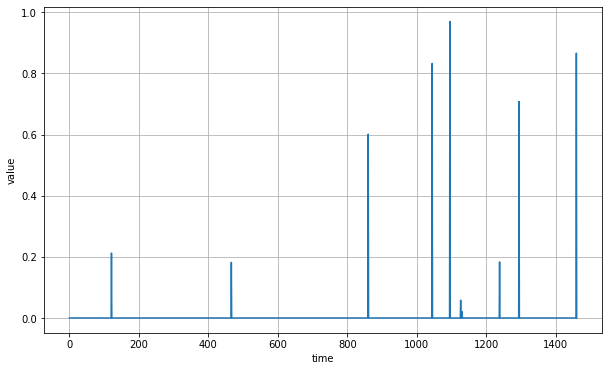

In [17]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()


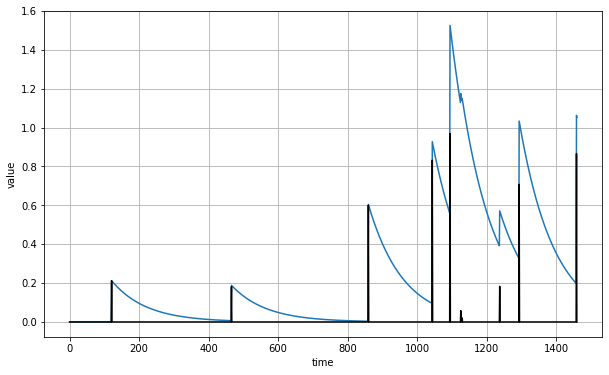

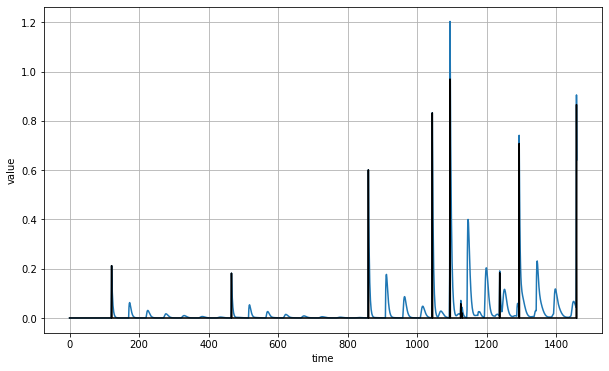

In [18]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

# EXPECTED OUTPUT
# 2.0.0-beta1 (or later)


TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
#!pip install tensorflow==2.0.0b1


In [0]:
import tensorflow as tf
print(tf.__version__)

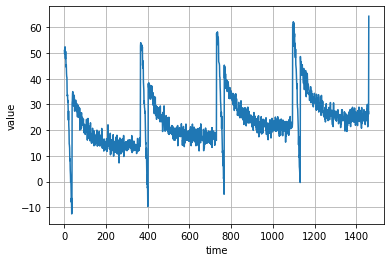

In [17]:
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
series = trend(time, 0.1)
amplitude =40
slope = 0.01
noise_level = 2

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# update the noise
series += noise(time, noise_level, seed=42)

plot_series(time, series)
plt.show()

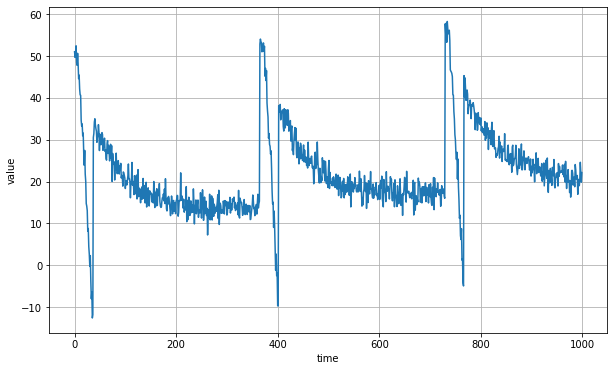

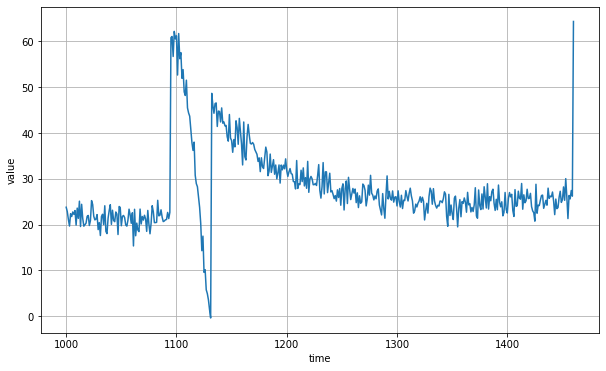

In [18]:
split_time = 1000 # YOUR CODE HERE
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
# Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0

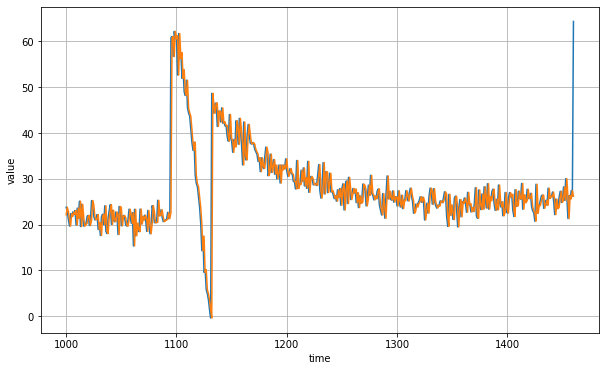

In [19]:
# Naive forecast, copy the data at time t-1
naive_forecast = series[split_time-1:-1] 
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

# Expected output: Chart similar to above, but with forecast overlay
                        

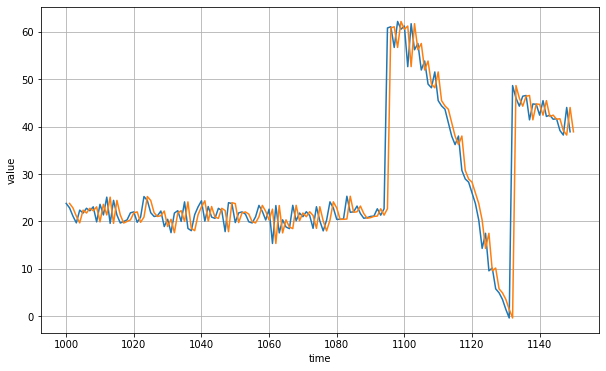

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

# EXPECTED - Chart with X-Axis from 1100-1250 and Y Axes with series value and projections. Projections should be time stepped 1 unit 'after' series

In [21]:
from tensorflow import keras
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
# Expected Output
# 19.578304
# 2.6011968

20.158266
2.586862


In [22]:
series

array([50.993427, 49.660896, 51.025326, ..., 27.43651 , 26.209599,
       64.32309 ], dtype=float32)

66.60637
4.0805964


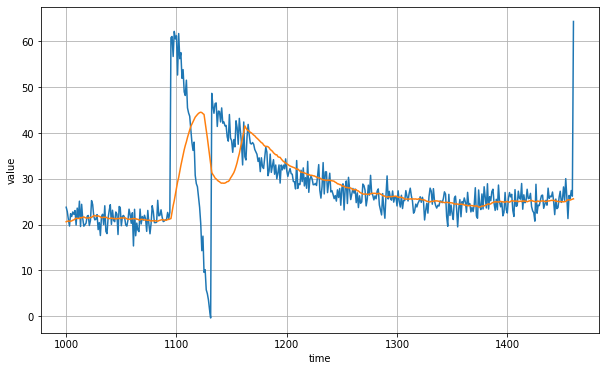

In [25]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  # YOUR CODE HERE
  forecasts = []
  for time in range(len(series) - window_size):
    forecasts.append(series[time:time + window_size].mean())
    

  return np.array(forecasts)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
    
# EXPECTED OUTPUT
# CHart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# EXPECTED OUTPUT
# 65.786224
# 4.3040023

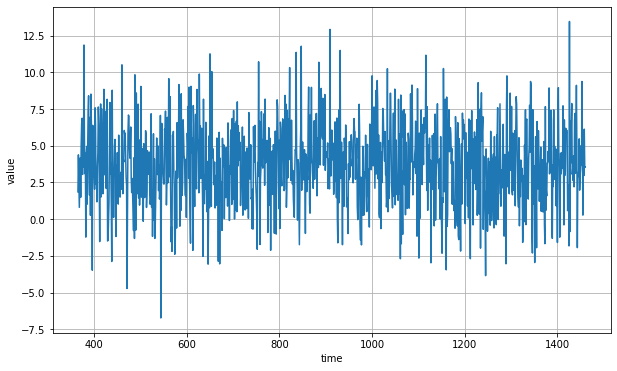

In [26]:
diff_series = (series[365:]-series[:-365])
diff_time = time[365:] # YOUR CODE HERE

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()
    
# EXPECETED OUTPUT: CHart with diffs

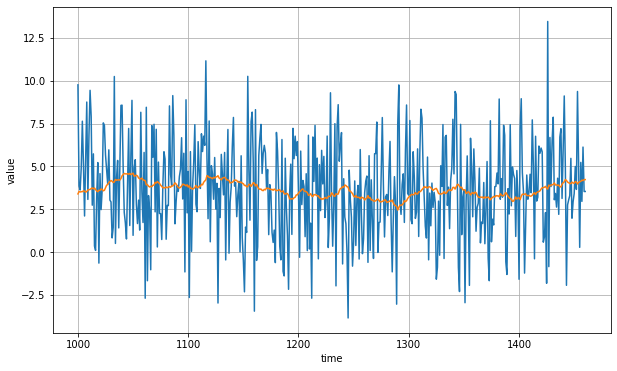

In [28]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()
            
# Expected output. Diff chart from 1100->1450 +
# Overlaid with moving average

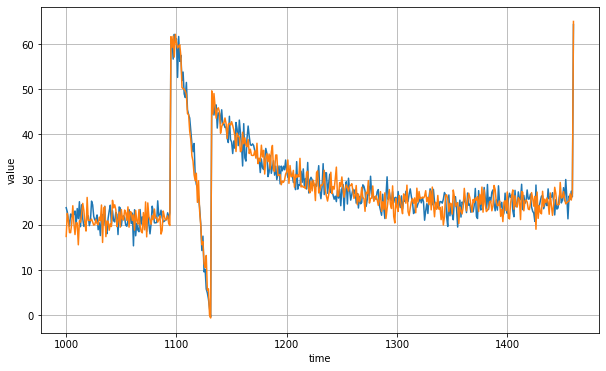

In [29]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()
# Expected output: Chart from 1100->1450+ on X. Same chart as earlier for time series, but projection overlaid looks close in value to it

8.475785
2.335724


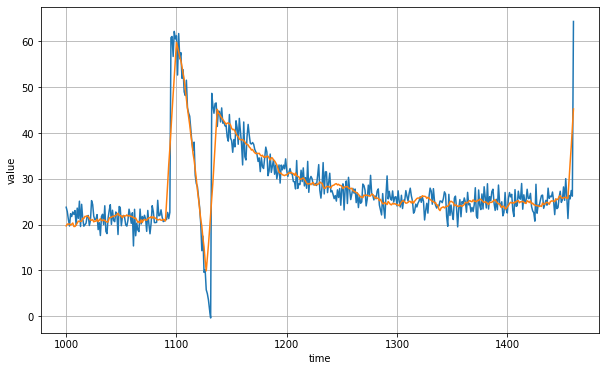

13.366833
2.2567513


In [30]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())
# EXPECTED OUTPUT
# 8.498155
# 2.327179
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()
            
# EXPECTED OUTPUT:
# Similar chart to above, but the overlaid projections are much smoother

print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
# EXPECTED OUTPUT
# 12.527958
# 2.2034433